## 1D CNN Model - Training

In [ ]:
"""
@authors: Maxime Tchibozo, Donggeun Kim
@affiliation: NYSPI, Columbia University
@date: Oct 2018 - Oct 2020
@overview: Evaluating the Experiment A 1D CNN model by plotting graphs and analyzing several metrics.
@input: Trained model checkpoints (.ckpt & metadata).
@output: Loss and accuracy plots, confusion matrices, ROC curves.
"""

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.callbacks import History
import pickle
from keras import initializers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import glob
import os
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve,roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
folder_root = '/content/drive/My Drive/BrainStateClassification/code/'#Update to your main folder, this folder must contain a data and a result subfolder
folder_data = folder_root + 'data/' #folder containing all the .mat files
folder_result = folder_root + 'data/plateau' #folder where your models and logs will be stored


In [4]:
os.chdir(folder_data)

In [5]:
Y = np.loadtxt('Y_hyp_v2.csv',delimiter=",")
X = np.loadtxt('X_hyp_v2.csv',delimiter=",")

In [6]:
from collections import Counter
Counter(Y)

Counter({0.0: 2200, 1.0: 1100, 2.0: 1100})

In [ ]:
np.shape(X)

(4400, 300)

In [ ]:
bias_regularization = 0.005
kernel_regularization = 0.005

def create_model():
    model = Sequential()
    model.add(Conv1D(128, (10), input_shape=(300,1)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                           bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                       bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                    bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
              bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
          bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
      bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(3, activation='softmax')) 
    return model


## Draw plots for each model

In [ ]:
model = create_model()
model.summary()

Cross-Validation Number  0 :


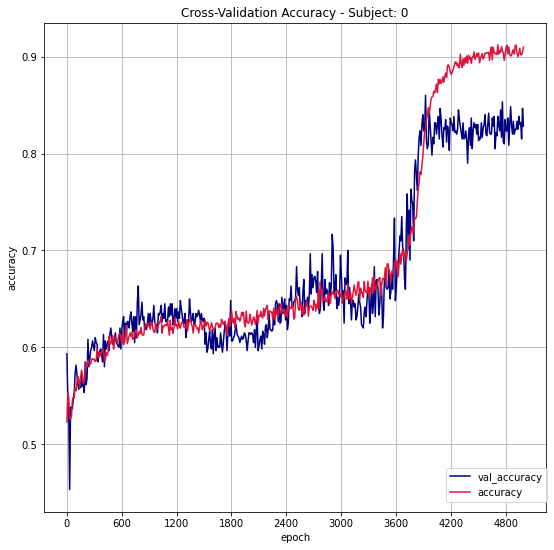

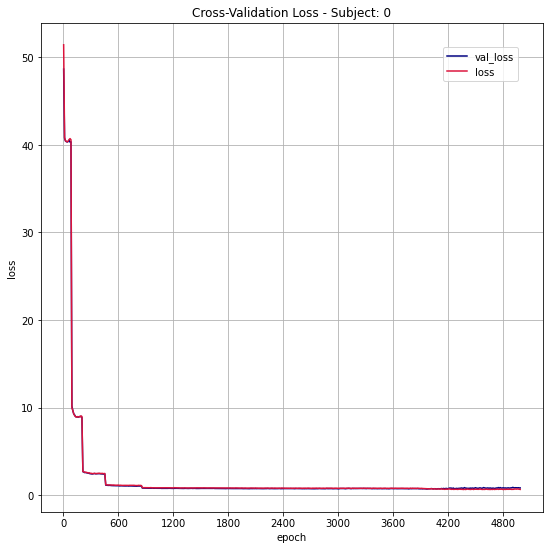

Cross-Validation Number  1 :


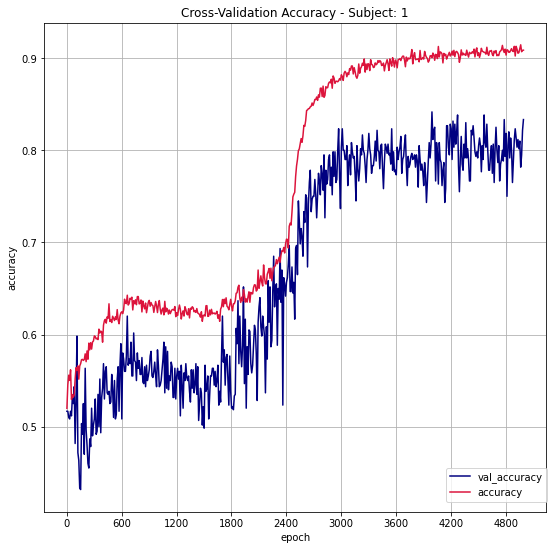

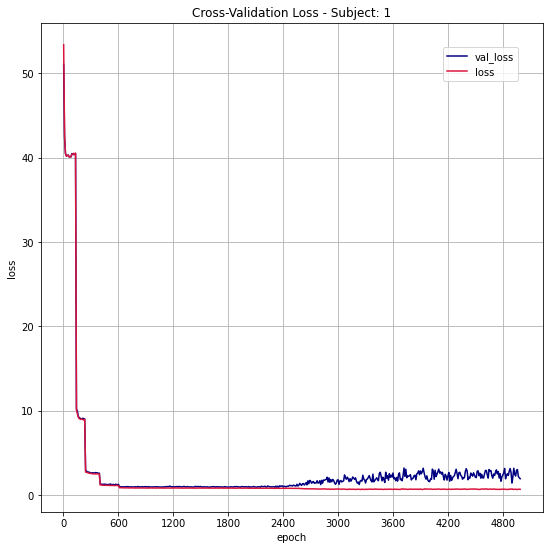

Cross-Validation Number  2 :


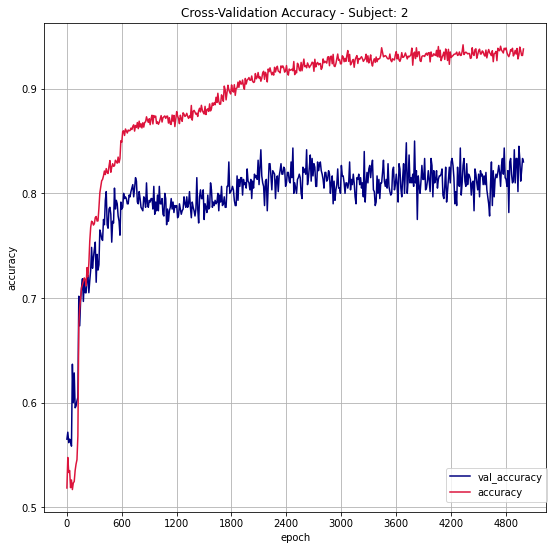

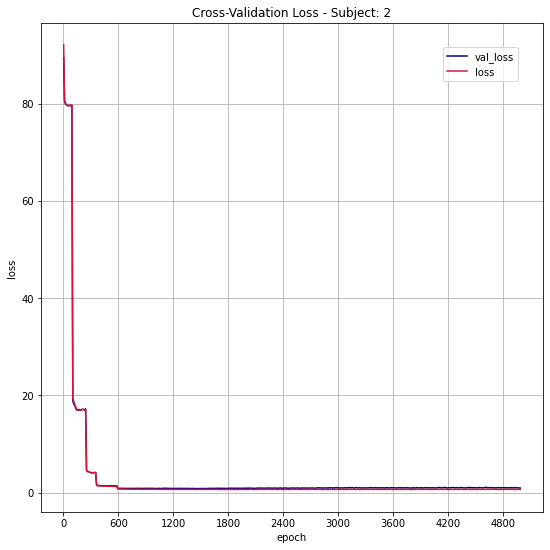

Cross-Validation Number  3 :


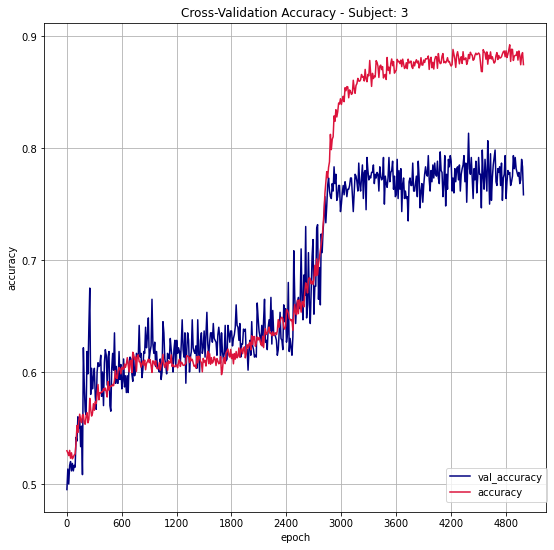

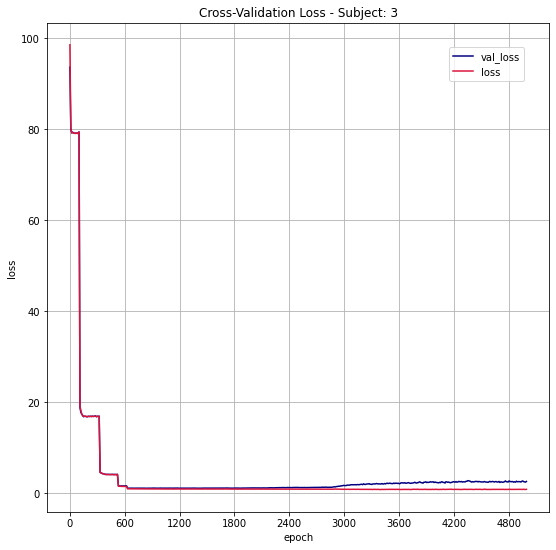

Cross-Validation Number  4 :


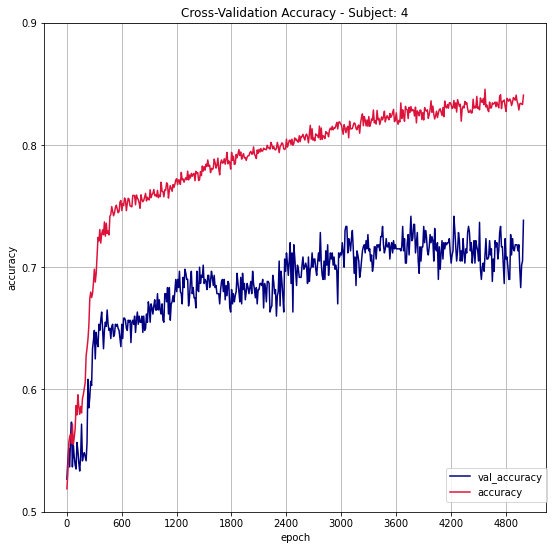

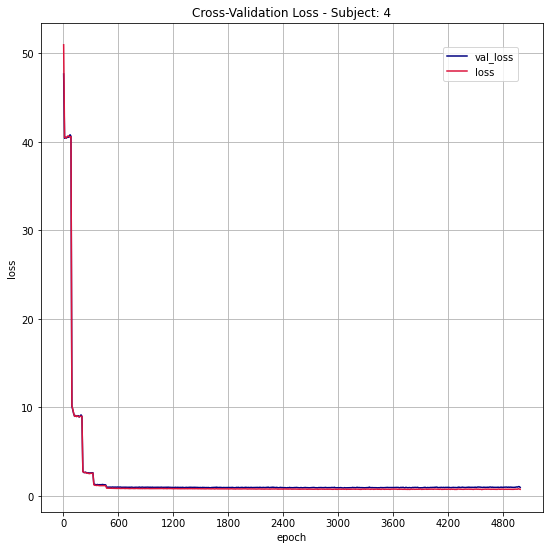

Cross-Validation Number  5 :


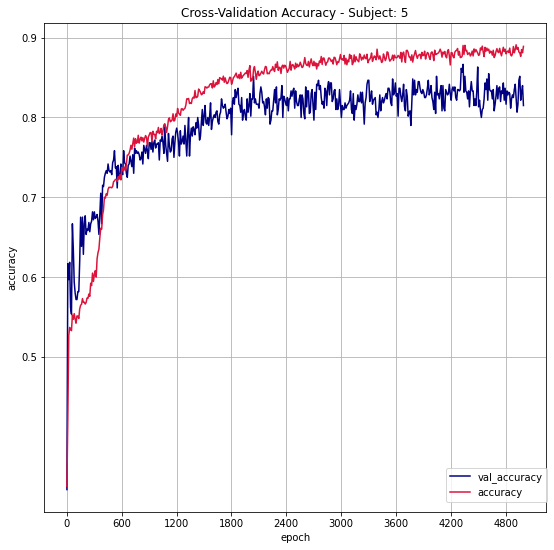

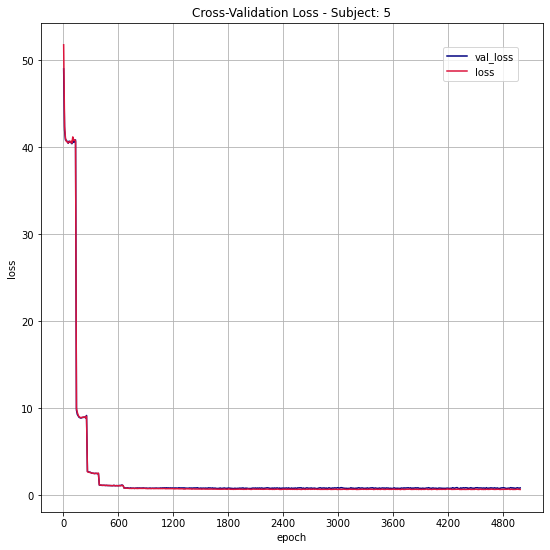

Cross-Validation Number  6 :


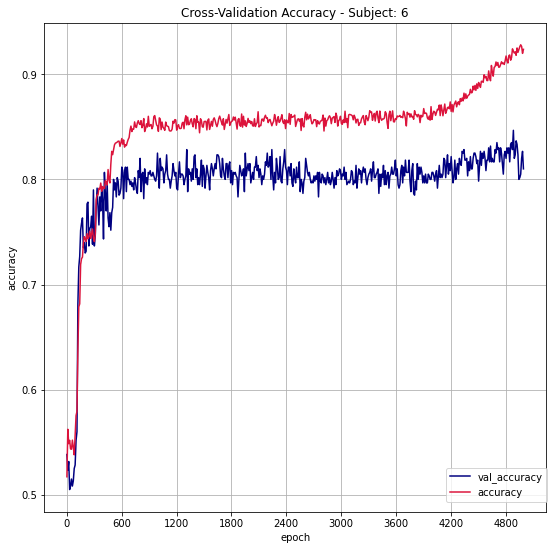

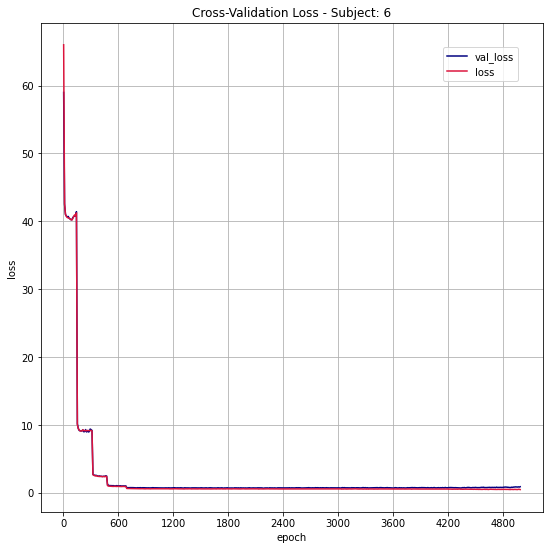

Cross-Validation Number  7 :


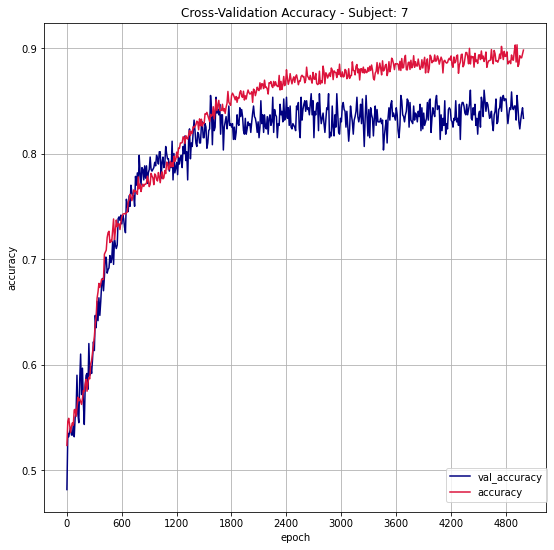

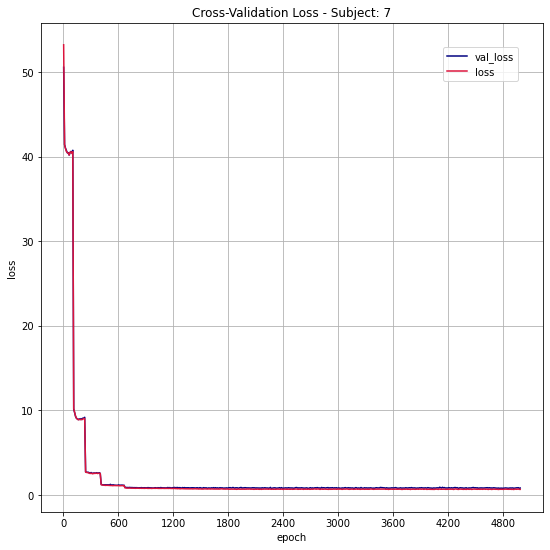

Cross-Validation Number  8 :


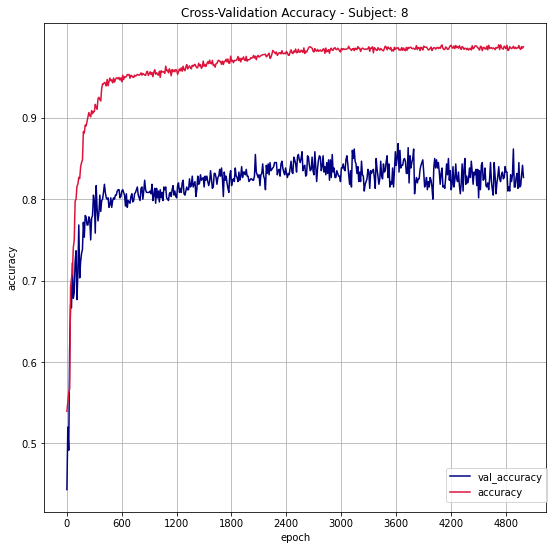

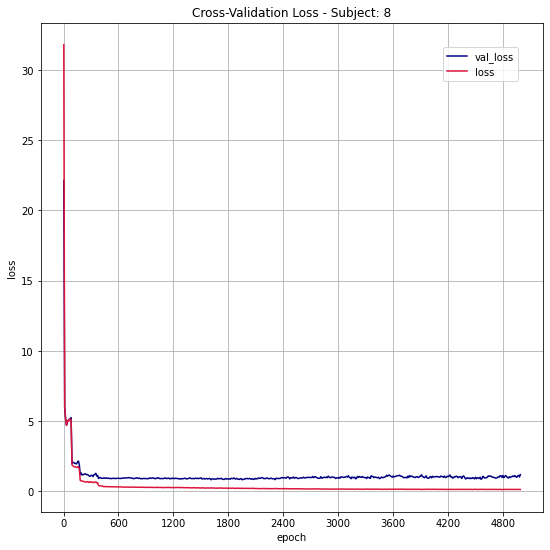

Cross-Validation Number  9 :


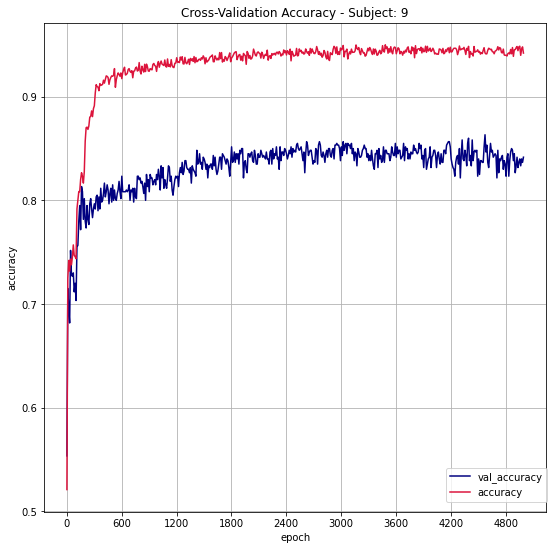

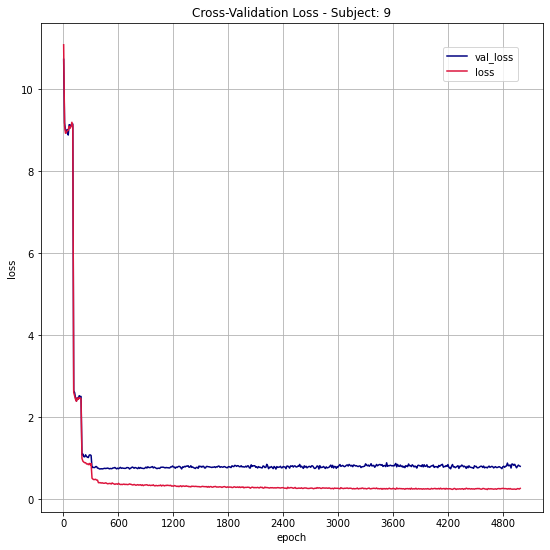

Cross-Validation Number  10 :


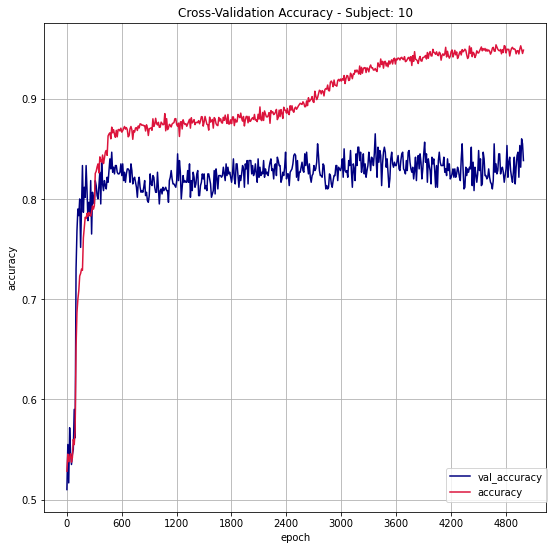

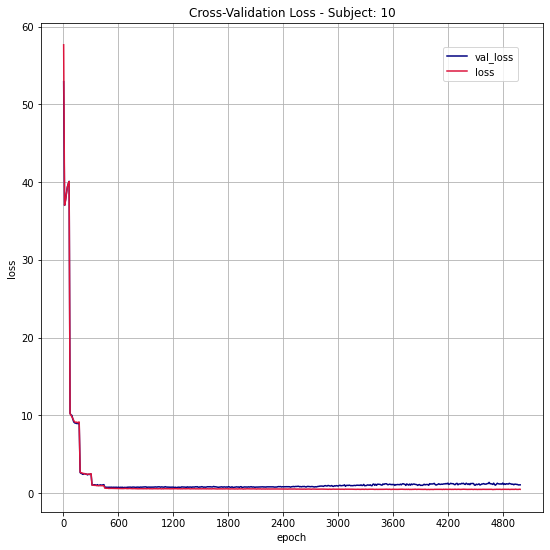

In [ ]:
import pandas as pd
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1

for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject):
        model_num = leave_one_idx
        print('Cross-Validation Number ',leave_one_idx,':')
        train_result = pd.read_csv(os.path.join('./plateau',f'training_holdout_regularized_{model_num}_{learn_rate}.log'))
        train_result = train_result[train_result.epoch < 5001][train_result.epoch > 1].iloc[::10]

        ax = figure(0).gca()
        ax.plot('epoch','val_accuracy',data=train_result,color='navy')
        ax.plot('epoch','accuracy',data=train_result,color='crimson')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(bbox_to_anchor=(0.8, 0.09), loc='upper left', borderaxespad=0.)
        plt.title('Cross-Validation Accuracy - Subject: '+str(leave_one_idx))
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.set_yticks(np.arange(0.5,1,0.1))
        fig = ax.get_figure()
        fig.set_figheight(9)
        fig.set_figwidth(9) 
        plt.grid()
        fig.savefig("acc_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")

        ax2 = figure(1).gca()
        ax2.plot('epoch','val_loss',data=train_result,color='navy')
        ax2.plot('epoch','loss',data=train_result,color='crimson')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0.)
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        plt.title('Cross-Validation Loss - Subject: '+str(leave_one_idx))

        fig2 = ax2.get_figure()
        fig2.set_figheight(9)
        fig2.set_figwidth(9)  
        plt.grid()    
        fig2.savefig("loss_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")

        show()

## Error for each fold

# **Manual Cross-Validation over X,y Dataset**

In [ ]:
#Warning: Running this code again will overwrite previously trained models.

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()

        savedpath = './plateau'
        print("created")
        
        #If the model weights have not yet been computed (i.e model did not exist), create weights file, otherwise, load the weights. Files are located in the plateau folder
        best_model_path=os.path.join(savedpath,f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")
        print(best_model_path)
        if len(glob.glob(os.path.join(savedpath, f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")))==0:
            print("created a new model")   
        else:
            print("loaded weights from file")
            model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])
        batch_size = 64
        epochs = 5000
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.00001) #Reduce learning rate when a metric has stopped improving.
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        csv_logger = keras.callbacks.CSVLogger(os.path.join(savedpath, f'training_holdout_regularized_{leave_one_idx}_{learn_rate}.log'))
        print("Before Fit")
        model.fit(X_train, Y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, Y_test_onehot),
                  callbacks=[csv_logger,checkpoint,reduce_lr])
        print(model.summary())
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        with open(os.path.join(savedpath,f"test_holdout_regularized_{leave_one_idx}_{learn_rate}.log"), 'a') as f:
            print("...Test size:" + "{:.3f}".format(X_test.shape[0]), file=f)
            print("...Test score:"+"{:.3f}".format(score),file=f)
            print("...Testing accuracy:" + "{:.3f}".format(acc), file=f)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))


0
to create
created
./plateau/weights_holdout_regularized_0_0.0045.best.hdf5
created a new model
Before Fit


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
94/94 [==============================] - 1s 12ms/step - loss: 0.7867 - accuracy: 0.6488 - val_loss: 0.7311 - val_accuracy: 0.6600
Epoch 2524/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7849 - accuracy: 0.6405 - val_loss: 0.7359 - val_accuracy: 0.6417
Epoch 2525/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7985 - accuracy: 0.6432 - val_loss: 0.7468 - val_accuracy: 0.6433
Epoch 2526/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8027 - accuracy: 0.6453 - val_loss: 0.7504 - val_accuracy: 0.6517
Epoch 2527/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8048 - accuracy: 0.6365 - val_loss: 0.7380 - val_accuracy: 0.6567
Epoch 2528/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7918 - accuracy: 0.6425 - val_loss: 0.7460 - val_accuracy: 0.6500
Epoch 2529/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7928 - accuracy: 0.6435 

In [ ]:
train_result

,epoch,accuracy,loss,val_accuracy,val_loss
2,2,0.523000,51.437332,0.593333,48.664043
12,12,0.553333,40.868073,0.546667,40.757729
22,22,0.548500,40.454777,0.531667,40.454899
32,32,0.528000,40.421520,0.453333,40.369999
42,42,0.526000,40.344913,0.538333,40.334499
...,...,...,...,...,...
2952,2952,0.658667,0.777137,0.640000,0.736028
2962,2962,0.659167,0.787479,0.651667,0.749778
2972,2972,0.654500,0.784784,0.643333,0.739246
2982,2982,0.656500,0.784011,0.651667,0.744175


## 1D CNN Confusion Matrix for each run

In [ ]:
from sklearn.metrics import confusion_matrix
import time

confusion_matrices = []
time_array = []

batch_size = 64

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])

        savedpath = './plateau'
 
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
 
        start = time.time()


        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        y_pred = np.argmax(model.predict(X_test),axis=1)
        confusion_matrices.append(confusion_matrix(Y_test, y_pred))
        time_diff = time.time() - start
        time_array.append(time_diff)
        print('time',time_diff)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))
print(confusion_matrices)

0
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 7.806758880615234
Test Accuracy for learning rate 0.0045 CV index 0 is : 0.862
1
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6379475593566895
Test Accuracy for learning rate 0.0045 CV index 1 is : 0.853
2
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6727120876312256
Test Accuracy for learning rate 0.0045 CV index 2 is : 0.857
3
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.839277982711792
Test Accuracy for learning rate 0.0045 CV index 3 is : 0.820
4
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.643136739730835
Test Accuracy for learning rate 0.0045 CV index 4 is : 0.747
5
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6347346305847168
Test Accuracy for learning rate 0.0045 CV index 5 is : 0.873
6
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6309309005737305
Test Accuracy for learning rate 0.0045 CV index 6 is : 0.850
7
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6261661052703857
Test Accuracy for learning rate 0.0045 CV index 7 is : 0.868
8
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.635195255279541
Test Accuracy for learning rate 0.0045 CV index 8 is : 0.870
9
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.8412292003631592
Test Accuracy for learning rate 0.0045 CV index 9 is : 0.863
10
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6445763111114502
Test Accuracy for learning rate 0.0045 CV index 10 is : 0.870
[array([[187,  12,   1],
       [  2, 173,  25],
       [  0,  43, 157]]), array([[184,  16,   0],
       [  9, 183,   8],
       [ 22,  33, 145]]), array([[180,  12,   8],
       [  8, 176,  16],
       [  3,  39, 158]]), array([[156,   7,  37],
       [ 10, 169,  21],
       [ 14,  19, 167]]), array([[163,  32,   5],
       [ 19, 162,  19],
       [ 16,  61, 123]]), array([[192,   8,   0],
       [ 13, 165,  22],
       [  4,  29, 167]]), array([[190,   6,   4],
       [ 30, 153,  17],
       [  9,  24, 167]]), array([[181,  13,   6],
       [ 10, 181,   9],
       [ 13,  28, 159]]), array([[183,   9,   8],
       [ 20, 152,  28],
       [  1,  12, 187]]), array([[186,   4,  10],
       [  4, 155,  41],
       [  2,  21, 177]]), array([[197,   0,   3],
       [ 13, 156,  31],
       [ 11,  20, 169]])]


In [ ]:
confusion_matrices

[array([[187,  12,   1],
        [  2, 173,  25],
        [  0,  43, 157]]), array([[184,  16,   0],
        [  9, 183,   8],
        [ 22,  33, 145]]), array([[180,  12,   8],
        [  8, 176,  16],
        [  3,  39, 158]]), array([[156,   7,  37],
        [ 10, 169,  21],
        [ 14,  19, 167]]), array([[163,  32,   5],
        [ 19, 162,  19],
        [ 16,  61, 123]]), array([[192,   8,   0],
        [ 13, 165,  22],
        [  4,  29, 167]]), array([[190,   6,   4],
        [ 30, 153,  17],
        [  9,  24, 167]]), array([[181,  13,   6],
        [ 10, 181,   9],
        [ 13,  28, 159]]), array([[183,   9,   8],
        [ 20, 152,  28],
        [  1,  12, 187]]), array([[186,   4,  10],
        [  4, 155,  41],
        [  2,  21, 177]]), array([[197,   0,   3],
        [ 13, 156,  31],
        [ 11,  20, 169]])]

In [ ]:
np.std(confusion_matrices,axis=0)

array([[11.58440102,  7.95233736,  9.87525499],
       [ 7.58423768, 10.76572461,  9.14890591],
       [ 6.8526402 , 13.0972207 , 16.04178428]])

## 1D CNN AUC, ROC, Precision, Recall for each run

In [ ]:
loss_list = []
auc_scores_list = []
roc_list = []

batch_size = 64

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])

        savedpath = './plateau'
 
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
 
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        loss_list.append(score)

        y_proba_pred = model.predict_proba(X_test)
        auc_score = roc_auc_score(Y_test_onehot,y_proba_pred)
        auc_scores_list.append(auc_score)
        #fpr , tpr , thresholds = roc_curve ( Y_test , y_proba_pred)
        #roc_list.append((fpr,tpr,thresholds))
        print(auc_score)


0
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Instructions for updating:
Please use `model.predict()` instead.
0.9553166666666666
1
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.94365
2
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9502541666666667
3
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9161770833333334
4
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.8565583333333332
5
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9367854166666666
6
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9526083333333334
7
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9324354166666667
8
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9525375
9
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9408458333333333
10
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.94475


In [ ]:
(np.argsort(-y_proba_pred )==0).astype(int)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

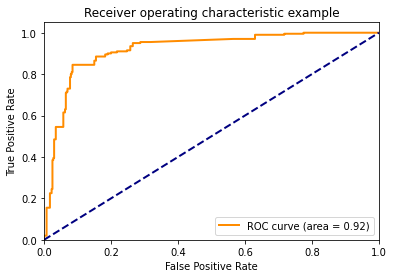

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], y_proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_onehot.ravel(),y_proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


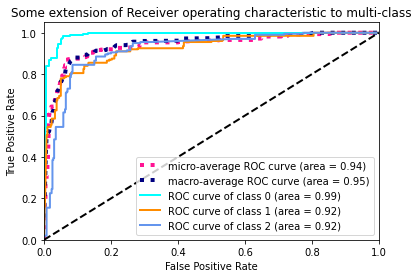

In [ ]:
n_classes=3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(np.mean(loss_list))
print(np.std(loss_list))
print(loss_list)

1.1821859370578418
0.48178603969011674
[1.1381261348724365, 1.7412304878234863, 0.6891832947731018, 2.1042087078094482, 0.9315676689147949, 0.8055248260498047, 0.7524473071098328, 0.7757989764213562, 1.9224517345428467, 1.1685853004455566, 0.9749208688735962]


In [ ]:
print(np.mean(auc_scores_list))
print(np.std(auc_scores_list))
print(auc_scores_list)

0.9350206439393939
0.027185664129565013
[0.9586250000000001, 0.94365, 0.9502541666666667, 0.9161770833333334, 0.8565583333333334, 0.9367854166666666, 0.9526083333333334, 0.9324354166666667, 0.9525374999999999, 0.9408458333333334, 0.94475]


Cross-Validation Number  7 :


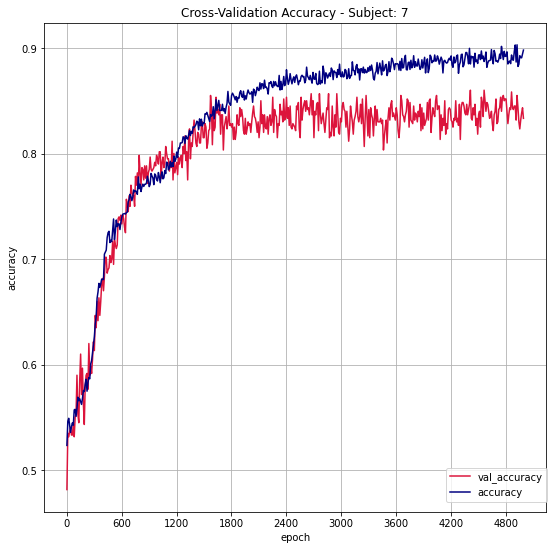

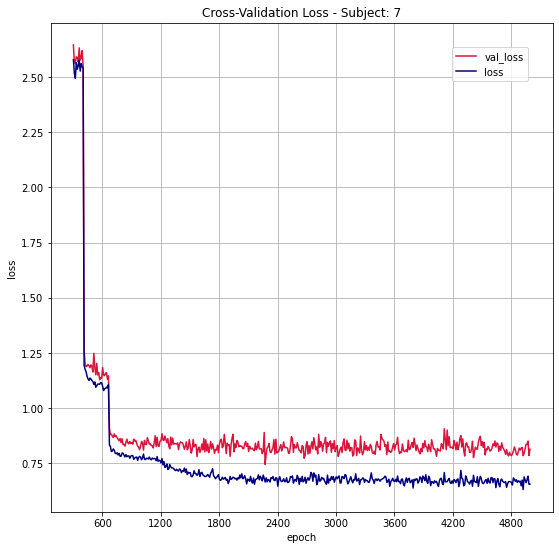

In [10]:
import pandas as pd
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1
#changed vdcnn_test to plateau
for learn_rate in [0.0045]:
    for leave_one_idx in [7]:
        model_num = leave_one_idx
        print('Cross-Validation Number ',leave_one_idx,':')
        train_result = pd.read_csv(os.path.join('./plateau',f'training_holdout_regularized_{model_num}_{learn_rate}.log'))
        train_result = train_result[train_result.epoch < 5001][train_result.epoch > 1].iloc[::10]

        ax = figure(0).gca()
        ax.plot('epoch','val_accuracy',data=train_result,color='crimson')
        ax.plot('epoch','accuracy',data=train_result,color='navy')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(bbox_to_anchor=(0.8, 0.09), loc='upper left', borderaxespad=0.)
        plt.title('Cross-Validation Accuracy - Subject: '+str(leave_one_idx))
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.set_yticks(np.arange(0.5,1,0.1))
        fig = ax.get_figure()
        fig.set_figheight(9)
        fig.set_figwidth(9) 
        plt.grid()
        #fig.savefig("fixed-acc_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")

        train_result = train_result[train_result.epoch > 300]

        ax2 = figure(1).gca()
        ax2.plot('epoch','val_loss',data=train_result,color='crimson')
        ax2.plot('epoch','loss',data=train_result,color='navy')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0.)
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        plt.title('Cross-Validation Loss - Subject: '+str(leave_one_idx))

        fig2 = ax2.get_figure()
        fig2.set_figheight(9)
        fig2.set_figwidth(9)  
        plt.grid()    
        fig2.savefig("fixed-loss_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+"_zoom.png")

        show()